Objective: Starting from Joyce's optimized distal-input TMS simulation, modify so that the input hits only a portion of the cells in the column as opposed to all of them, modeling how TMS would only activate a portion of the supragranular axons providing distal input. Also, add a current injection to the somas of a portion of each cell type to model how TMS activates a portion of their axons directly, which then causes current to reach the soma through the AP propagating backwards from the axon.

Tuning will come last, but the distal input modification should simply involve including the probability parameter, assuming it works as expected.

The soma current injection which models direct activation by TMS is the main distinguishing addition. This could be accomplished with another drive that hits the somas, but requires changing the allowed synapses to the somas of pyramidal cells and introduces the nuances of synaptic dynamics. The ideal approach would be to add a current injection rather than a synapse, which could be achieve with HNN's tonic bias, except that the bias cannot target cells based on probability.


In [1]:
import hnn_core
from hnn_core import calcium_model, read_params, simulate_dipole, average_dipoles, read_dipole
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import pickle
import numpy as np
from copy import deepcopy

%matplotlib inline

In [2]:
with open("BETA9_opt_net.pkl", "rb") as f:
    BETA9_opt_net = pickle.load(f)
BETA9_opt_net: hnn_core.Network

In [3]:
exp_dpl = read_dipole('BETA09_s1loc_10mm.txt')

In [ ]:
# print(BETA9_opt_net.external_drives["evdist2"])
# for k, v in dict(BETA9_opt_net.external_drives["evdist2"]).items(): print(f"{k}: {v}") 

<External drive 'evdist2'
drive class: evoked
target location: distal
target cell types: ['L2_basket', 'L2_pyramidal', 'L5_pyramidal']
number of drive cells: 235
cell-specific: True
dynamic parameters:
	mu: 6.528485
	sigma: 1.0040786
	numspikes: 1
event times instantiated for 5 trials>
type: evoked
location: distal
n_drive_cells: 235
event_seed: 2
conn_seed: 3
dynamics: {'mu': 6.528485, 'sigma': 1.0040786, 'numspikes': 1}
events: [[[6.1100273640381015], [8.324408573522051], [6.579252928121693], [6.971512077313051], [6.215429685621797], [8.225905681935876], [6.620061704177025], [6.52959807606346], [7.865502512845261], [8.285075067413066], [7.003399951502294], [5.813188781395173], [8.08615140295222], [6.214882655511632], [6.656955572787953], [6.80587766808036], [6.608237400657112], [6.7503896465893245], [7.415983159066466], [6.476308809106435], [6.436160053191647], [7.198193433840111], [7.863118497416553], [6.7576891242895964], [6.725277589573015], [7.819333885478847], [6.976637789106427

In [ ]:
tms_net = deepcopy(BETA9_opt_net)
# Delete first distal drive evdist2
del tms_net.external_drives["evdist2"]
# Add distal w/ probability
tms_net.add_evoked_drive(
    name="tms_distal",
    mu=6.528485,
    sigma=1.0040786,
    numspikes=1,
    location="distal",
    # n_drive_cells=None,
    # cell_specific=None,
    weights_ampa={'L2_basket': 0.0024741719999999997, 'L2_pyramidal': 0.0031460039999999996, 'L5_pyramidal': 0.030831731999999997},
    weights_nmda={'L2_basket': 0.039215124, 'L2_pyramidal': 0.004143708, 'L5_pyramidal': 0.006008543999999999},
    space_constant=1e6,
    synaptic_delays={'L2_basket': 0.1, 'L2_pyramidal': 0.1, 'L5_pyramidal': 0.1},
    probability=0.8,
)
# Add direct w/ cell-type specific probability
t0 = 6.5 # Tune
tms_net.add_tonic_bias(
    bias_name="tms_direct",
    t0=t0,
    tstop=t0+0.3,
    amplitude=      {'L2_basket':    2, 
                     'L2_pyramidal': 10, 
                     'L5_basket':    2,
                     'L5_pyramidal': 30},
    probability=    {'L2_basket':    0.5,
                     'L2_pyramidal': 0.5,
                     'L5_basket':    0.5,
                     'L5_pyramidal': 0.5}, # Tune
)

In [6]:
direct_init_dpl = simulate_dipole(tms_net, tstop=300)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from C:\Users\jacob\Documents\Thesis\hnn_tms_direct\hnn_core\mod\nrnmech.dll
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...


In [7]:
with open('distal_opt_dpls.pkl', 'rb') as f:
    distal_opt_dpls = pickle.load(f)
# distal_opt_dpls = simulate_dipole(BETA9_opt_net, tstop=300, n_trials=5)


In [8]:
# with open('distal_opt_dpls.pkl', 'wb') as f:
#     pickle.dump(distal_opt_dpls, f)
# average_dipoles(distal_opt_dpls).write('av_distal_opt_dpl.txt')

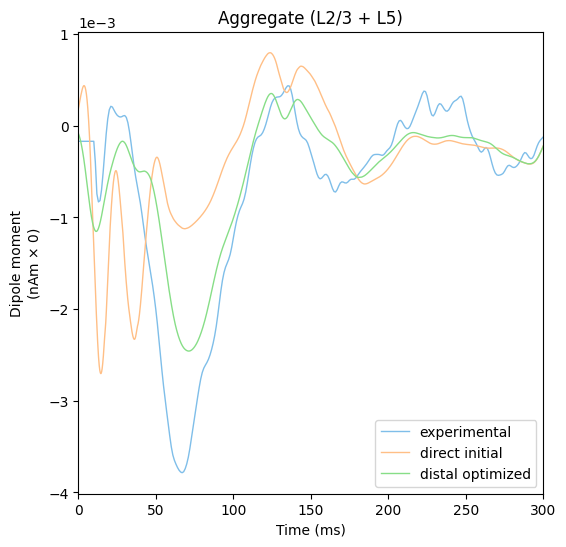

In [9]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6, 6))

scale_factor = 0.1
smooth_window_len = 20

direct_init_dpl_plot = deepcopy(direct_init_dpl)[0]
direct_init_dpl_plot.scale(scale_factor)
direct_init_dpl_plot.smooth(smooth_window_len)

distal_opt_dpl_plot = average_dipoles(distal_opt_dpls)
distal_opt_dpl_plot.scale(scale_factor)
distal_opt_dpl_plot.smooth(smooth_window_len)

exp_dpl_plot = deepcopy(exp_dpl)
exp_dpl_plot.times *= 1e3

exp_dpl_plot.plot(ax=axes, layer='agg', show=False, color='tab:blue')
direct_init_dpl_plot.plot(ax=axes, layer='agg', show=False, color='tab:orange')
distal_opt_dpl_plot.plot(ax=axes, layer='agg', show=False, color='tab:green')
axes.legend(['experimental', 'direct initial', 'distal optimized'])
# optim.net_.cell_response.plot_spikes_hist(ax=axes[1], show=False)
plt.show()